In [1]:
import numpy as np
import h5py
import matplotlib.pyplot as plt

In [2]:
# Part A

f = h5py.File('assign2_data1.h5', 'r')
dataKeys = list(f.keys())
print('The data keys are:' + str(dataKeys))

# Gathering the  train images, test images, train labels and test labels.
testims = f['testims']
testlbls = f['testlbls']
trainims = f['trainims']
trainlbls = f['trainlbls']
print('The size of testims is: ' + str(np.shape(testims)))
print('The size of testlbls is: ' + str(np.shape(testlbls)))
print('The size of trainims is: ' + str(np.shape(trainims)))
print('The size of trainlbls is: ' + str(np.shape(trainlbls)))

The data keys are:['testims', 'testlbls', 'trainims', 'trainlbls']
The size of testims is: (1000, 32, 32)
The size of testlbls is: (1000,)
The size of trainims is: (1900, 32, 32)
The size of trainlbls is: (1900,)


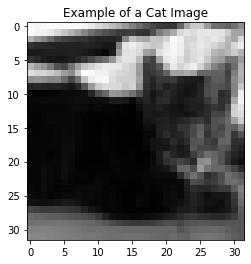

In [3]:
figureNum = 0
plt.figure(figureNum)
plt.title('Example of a Cat Image')
plt.imshow(trainims[0].T, cmap='gray')
plt.show()

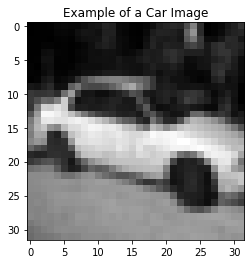

In [4]:
figureNum = 0
plt.figure(figureNum)
plt.title('Example of a Car Image')
plt.imshow(trainims[1500].T, cmap='gray')
plt.show()

In [5]:
class HiddenLayer:

    def __init__(self, neuronNum, neuronSize, mean, std):
        
        '''
        This class creates a hidden laer for neural network. 
        Weights and bias are initially random Gaussian distribution.

        INPUTS:

            neuronNum    : neuronNum is the features a neuron holds.
            neuronSize   : neuronSize is the number of neurons in a hidden layer.
            mean         : mean for Gaussian distribution.
            std          : Standard deviation for Gaussian distribution.

        RETURNS:

        ''' 
        
        np.random.seed(15)
        self.weights = np.random.normal( loc=mean, scale=std, size=(neuronNum,neuronSize))
        self.bias = np.random.normal( loc=mean, scale=std, size=(1,neuronSize))
        self.Z = None
        self.A = None
        self.grad = None
        self.dB = None
        self.dW = None
        self.error = None
        self.momentum_dw = 0
        self.momentum_db = 0


In [6]:
class MLP:
    def __init__(self, momentum = False, momentumCoef = 0):
        
        '''
        This class creates a multilayer perceptron network. 

        INPUTS:

            momentum     : momentum is the boolean for the network which indicates 
                           whether the momentum learning will be done or not
                           
            momentumCoef : Coefficient of momentum learning


        RETURNS:

        ''' 
        
        self.momentum = momentum
        self.momentumCoef = momentumCoef
        self.layers = list()
        self.batchSize = 0
        
    
    def addLayer(self, layer):
        '''
        This function adds a HiddenLayer class to the network. 

        INPUTS:

            layer        : layer is an instance of HiddenLayer class

        RETURNS:

        ''' 
        
        self.layers.append(layer)
    
    def tanh(self, x):
        '''
        This function is the hyperbolic tangent for the activation functions of each neuron.
        INPUTS:

            x            : x is the weighted sum which will be pushed to activation function.

        RETURNS:
        
            result       : result is the hyperbolic tangent of the input x.
        ''' 
        
        result = 2 / (1 + np.exp(-2*x)) - 1
        return result
    
    def der_tanh(self, x):
        '''
        This function is the derivative hyperbolic tangent. This function will be used in backpropagation.
        INPUTS:

            x            : x is the input.

        RETURNS:
        
            result       : result is the derivative of hyperbolic tangent of the input x.
        ''' 
        result = 1 - self.tanh(x)**2
        return result    
    
    def MSE(self, y, y_pred):
        '''
        MSE is the loss function for the network. 
        INPUTS:

            y            : y is the labels for our data.
            y_pred       : y_pred is the network's prediction.

        RETURNS:
        
            loss         : loss is the mean squared error between y and y_pred.
        ''' 
        error = y - y_pred
        loss = np.mean(error**2)
        return loss
    
    def der_MSE(self, y, y_pred):
        '''
        der_MSE is the derivative of loss function for the network. 
        This function will be used for backpropagation.
        INPUTS:

            y            : y is the labels for our data.
            y_pred       : y_pred is the network's prediction.

        RETURNS:
        
            result       : result is the derivative of the MSE between y and y_pred.
        '''         
        result = y_pred - y
        return result
            
    def MCE(self, y, y_pred):
        '''
        MCE is the accuracy of our network. Mean classification error will be calculated to find accuracy.
        INPUTS:

            y            : y is the labels for our data.
            y_pred       : y_pred is the network's prediction.

        RETURNS:
        
                         : returns the accuracy between y and y_pred.
        '''         
        count = 0
        for i in range(len(y)):
            if(y[i] == y_pred[i]):
                count += 1
        return 100 * (count / len(y))
        
    def forward(self, data):
        '''
        forward function is the forward propagation.
        INPUTS:

            data         : data is the input which will pushed to forward propagation.

        RETURNS:
        
                         : returns the prediction of the network.
        '''          
        
        layerSize = np.shape(self.layers)[0]
        for i in range(layerSize):
            # 1st Hidden Layer
            if (i == 0):
                self.layers[i].A = data.dot(self.layers[i].weights) + self.layers[i].bias
                self.layers[i].Z = self.tanh(self.layers[i].A)
            # Other Hidden Layers and Output Layer
            else:
                self.layers[i].A = (self.layers[i-1].Z).dot(self.layers[i].weights) + self.layers[i].bias
                self.layers[i].Z = self.tanh(self.layers[i].A)
    
        return self.layers[-1].Z
    
                
    def back_propagation(self, data, label):
        '''
        back_propagation function is the back propagation algorithm for weight and bias updates.
        back_propagation function first calls forward function to predict the output of network which us y_pred.
        INPUTS:

            data         : data is the input.
            label        : label is the labels of the data.

        RETURNS:
        
        '''         
        
        layerSize = np.shape(self.layers)[0]
        y_pred = self.forward(data)

        for i in range(layerSize)[::-1]:
            # Output Layer
            if (i == layerSize - 1):
                self.layers[i].error = self.der_MSE(label, y_pred)
                self.layers[i].error = np.array(self.layers[i].error).reshape(-1,1)
                self.layers[i].grad = (self.layers[i].error) * (self.der_tanh(self.layers[i].A))
                self.layers[i].dW = (self.layers[i-1].Z).T.dot(self.layers[i].grad)
                self.layers[i].dB = np.sum(self.layers[i].grad, axis=0, keepdims=True)
                
            # 1st Hidden Layer    
            elif(i == 0):
                self.layers[i].error = (self.layers[i+1].grad).dot(self.layers[i+1].weights.T)
                self.layers[i].grad = (self.layers[i].error) * self.der_tanh(self.layers[i].A)
                self.layers[i].dW = data.T.dot(self.layers[i].grad)
                self.layers[i].dB = np.sum(self.layers[i].grad, axis=0, keepdims=True)
                
            # Other Hidden Layers    
            else:
                self.layers[i].error = (self.layers[i+1].grad).dot(self.layers[i+1].weights.T)
            
                self.layers[i].grad = (self.layers[i].error) * self.der_tanh(self.layers[i].A)
                self.layers[i].dW = (self.layers[i-1].Z).T.dot(self.layers[i].grad)
                self.layers[i].dB = np.sum(self.layers[i].grad, axis=0, keepdims=True)
            
    
    def update_weights(self, data, label, learningRate):
        '''
        update_weights function updates the weights with the gradients found with back_propagation.
        INPUTS:

            data         : data is the input.
            label        : label is the labels of the data.
            learnigRate  : learningRate is the coefficient for the weight update.

        RETURNS:
        
        '''    
        
        
        layerSize = np.shape(self.layers)[0]
        self.back_propagation(data,label)
        # If momentum is used.
        if( self.momentum == True ):
            for i in range(layerSize):
                
                self.layers[i].momentum_dw = self.layers[i].dW + (self.momentumCoef * self.layers[i].momentum_dw)
                self.layers[i].momentum_db = self.layers[i].dB + (self.momentumCoef * self.layers[i].momentum_db)

                self.layers[i].weights -= (learningRate * self.layers[i].momentum_dw)/self.batchSize
                self.layers[i].bias -= (learningRate * self.layers[i].momentum_db)/self.batchSize
        
        #If momentum is not used.
        else:
            for i in range(layerSize):  

                self.layers[i].weights -= (learningRate * self.layers[i].dW)/self.batchSize
                self.layers[i].bias -= (learningRate * self.layers[i].dB)/self.batchSize
            
    
    def predict(self, y_pred):
        '''
        predict function predicts and output from the network's output y_pred.
        INPUTS:

            y_pred       : MLP's output.

        RETURNS:
        
                         : returns the label for prediction of the network.
        '''         
        
        return np.where(y_pred>=0, 1, -1)
    
    
    def trainNetwork(self, data, label, testData, testLabel, learningRate, batchNum, epoch):
        '''
        trainNetwork function calls the update_weights function to train the network over mini-batches
        for fiven number of epochs.
        INPUTS:

            data         : data is the training data.
            label        : label is the labels of the data.
            testData     : testData is the test data.
            testLabel    : testLabel is the labels of the testData.
            learnigRate  : learningRate is the coefficient for the weight update.
            batchNum     : batchNum is the number of mini-batches.
            epoch        : Number of times the network train the whole data.

        RETURNS:
        
            MSE_loss     : MSE loss of the training data.
            MCE_loss     : MCE loss of the training data.
            test_MSE     : MSE loss of the test data.
            test_MCE     : MCE loss of the test data.
        '''         
        
        MSE_loss = list()
        MCE_loss = list()
        test_MSE = list()
        test_MCE = list()
        np.random.seed(7)
        
        for i in range(epoch):
            
            randomIndexes = np.random.permutation(len(label)) 
            data = data[randomIndexes] 
            label = label[randomIndexes]
            
            batchLength = len(label) / batchNum
            self.batchSize = batchLength
            for j in range(batchNum):

                start = int(batchLength*j)
                end = int(batchLength*(j+1))
                self.update_weights(data[start:end],label[start:end],learningRate)
            
            y_pred = self.forward(data)
            loss = self.MSE(label, y_pred)
            MSE_loss.append(loss)
            
            
            loss_MCE = self.MCE(label, self.predict(y_pred))
            MCE_loss.append(loss_MCE)
            
            y_pred_test = self.forward(testData)
            test_loss = self.MSE(testLabel, y_pred_test)
            test_MSE.append(test_loss)
            
            
            test_loss_MCE = self.MCE(testLabel, self.predict(y_pred_test))
            test_MCE.append(test_loss_MCE)
            
        return MSE_loss, MCE_loss, test_MSE, test_MCE

In [7]:
trainimages = np.asarray(trainims)
testimages = np.asarray(testims)
trainlabels = np.asarray(trainlbls)
testlabels = np.asarray(testlbls)

trainlabels = np.where(trainlabels == 0 , -1, 1)
testlabels = np.where(testlabels == 0 , -1, 1)

trainlabels = trainlabels.reshape(-1,1)
testlabels = testlabels.reshape(-1,1)

train_img_flat = trainimages.reshape(1900, 32**2)
test_img_flat = testimages.reshape(1000, 32**2)

In [8]:
# learningRate = np.arange(0.1, 0.5, 0.05)
# N_layer = np.arange(10,20,2)

# best_lr = 0
# best_n = 0
# mse_best = np.inf

# for n in N_layer:
#     print(n)
#     neuralNet = MLP() 
#     neuralNet.addLayer(HiddenLayer(32**2, n, 0, 0.02)) 
#     neuralNet.addLayer(HiddenLayer(n, 1, 0, 0.02)) 
#     for lr in learningRate:
#         mse_loss, mce_loss, test_mse, test_mce = neuralNet.trainNetwork(train_img_flat/255, trainlabels, test_img_flat/255, testlabels, lr, 50, 300)
#         if(mse_loss[-1] < mse_best):
#             best_lr = lr
#             best_n = n
#             mse_best = mse_loss[-1]     

In [9]:
# print("Best Learning Rate: " +str(best_lr))
# print("Best Number of Hidden Neuron: " +str(best_n))

In [10]:
best_lr = 0.35
best_n = 20

neuralNet = MLP() 
neuralNet.addLayer(HiddenLayer(32**2, best_n, 0, 0.02)) 
neuralNet.addLayer(HiddenLayer(best_n, 1, 0, 0.02)) 

mse_loss, mce_loss, test_mse, test_mce = neuralNet.trainNetwork(train_img_flat/255, trainlabels, test_img_flat/255, testlabels, best_lr, 50, 250)

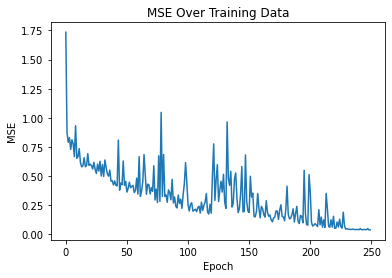

In [11]:
figureNum = 0
plt.figure(figureNum)
plt.plot(mse_loss)
plt.title('MSE Over Training Data')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.show()

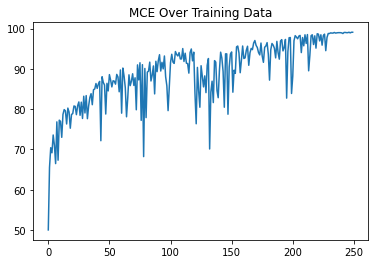

In [12]:
figureNum += 1
plt.figure(figureNum)
plt.plot(mce_loss)
plt.title('MCE Over Training Data')
plt.show()

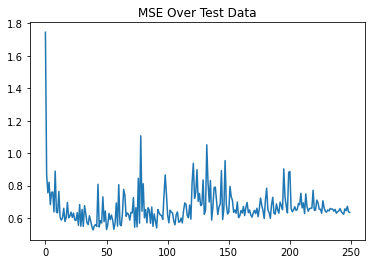

In [13]:
figureNum += 1
plt.figure(figureNum)
plt.plot(test_mse)
plt.title('MSE Over Test Data')
plt.show()

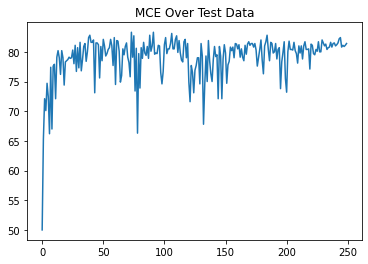

In [14]:
figureNum += 1
plt.figure(figureNum)
plt.plot(test_mce)
plt.title('MCE Over Test Data')
plt.show()

In [15]:
print(np.argmax(test_mce))

73


In [16]:
# Part C

best_lr = 0.35
high_n = 200

neuralNet = MLP() 
neuralNet.addLayer(HiddenLayer(32**2, high_n, 0, 0.02)) 
neuralNet.addLayer(HiddenLayer(high_n, 1, 0, 0.02)) 

mse_loss_highN, mce_loss_highN, test_mse_highN, test_mce_highN = neuralNet.trainNetwork(train_img_flat/255, trainlabels, test_img_flat/255, testlabels, best_lr, 50, 250)

In [17]:
best_lr = 0.35
low_n = 4

neuralNet = MLP() 
neuralNet.addLayer(HiddenLayer(32**2, low_n, 0, 0.02)) 
neuralNet.addLayer(HiddenLayer(low_n, 1, 0, 0.02)) 

mse_loss_lowN, mce_loss_lowN, test_mse_lowN, test_mce_lowN = neuralNet.trainNetwork(train_img_flat/255, trainlabels, test_img_flat/255, testlabels, best_lr, 50, 250)

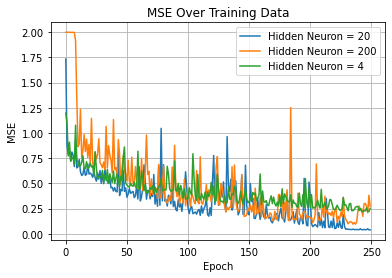

In [18]:
figureNum += 1
plt.figure(figureNum)
plt.plot(mse_loss)
plt.plot(mse_loss_highN)
plt.plot(mse_loss_lowN)

plt.title('MSE Over Training Data')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.legend(["Hidden Neuron = " + str(best_n), "Hidden Neuron = " + str(high_n), "Hidden Neuron = " + str(low_n)])
plt.grid()
plt.show()

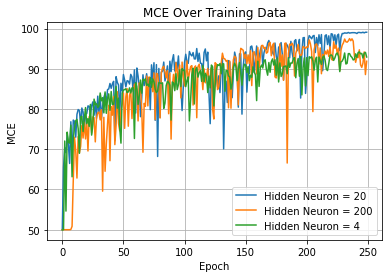

In [19]:
figureNum += 1
plt.figure(figureNum)
plt.plot(mce_loss)
plt.plot(mce_loss_highN)
plt.plot(mce_loss_lowN)

plt.title('MCE Over Training Data')
plt.xlabel('Epoch')
plt.ylabel('MCE')
plt.legend(["Hidden Neuron = " + str(best_n), "Hidden Neuron = " + str(high_n), "Hidden Neuron = " + str(low_n)])
plt.grid()
plt.show()

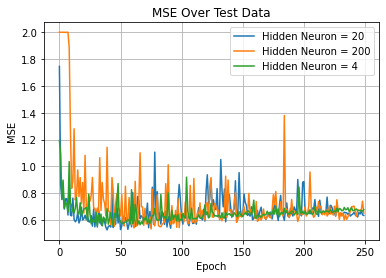

In [20]:
figureNum += 1
plt.figure(figureNum)
plt.plot(test_mse)
plt.plot(test_mse_highN)
plt.plot(test_mse_lowN)

plt.title('MSE Over Test Data')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.legend(["Hidden Neuron = " + str(best_n), "Hidden Neuron = " + str(high_n), "Hidden Neuron = " + str(low_n)])
plt.grid()
plt.show()

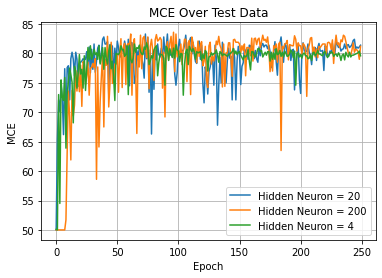

In [21]:
figureNum += 1
plt.figure(figureNum)
plt.plot(test_mce)
plt.plot(test_mce_highN)
plt.plot(test_mce_lowN)

plt.title('MCE Over Test Data')
plt.xlabel('Epoch')
plt.ylabel('MCE')
plt.legend(["Hidden Neuron = " + str(best_n), "Hidden Neuron = " + str(high_n), "Hidden Neuron = " + str(low_n)])
plt.grid()
plt.show()

In [22]:
# Part D

neuralNet_2L = MLP() 
neuralNet_2L.addLayer(HiddenLayer(32**2, 512, 0, 0.02)) 
neuralNet_2L.addLayer(HiddenLayer(512, 64, 0, 0.02))
neuralNet_2L.addLayer(HiddenLayer(64, 1, 0, 0.02)) 

mse_loss_2l, mce_loss_2l, test_mse_2l, test_mce_2l = neuralNet_2L.trainNetwork(train_img_flat/255, trainlabels,test_img_flat/255, testlabels, 0.35, 50, 200)

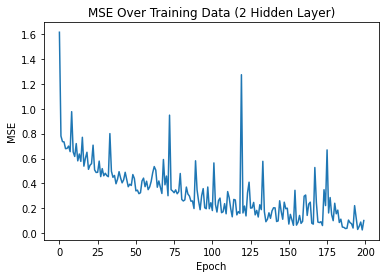

In [23]:
figureNum += 1
plt.figure(figureNum)
plt.title('MSE Over Training Data (2 Hidden Layer)')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.plot(mse_loss_2l)
plt.show()

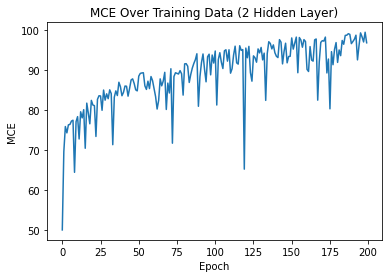

In [24]:
figureNum += 1
plt.figure(figureNum)
plt.title('MCE Over Training Data (2 Hidden Layer)')
plt.xlabel('Epoch')
plt.ylabel('MCE')
plt.plot(mce_loss_2l)
plt.show()

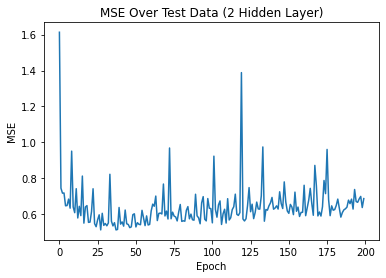

In [25]:
figureNum += 1
plt.figure(figureNum)
plt.title('MSE Over Test Data (2 Hidden Layer)')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.plot(test_mse_2l)
plt.show()

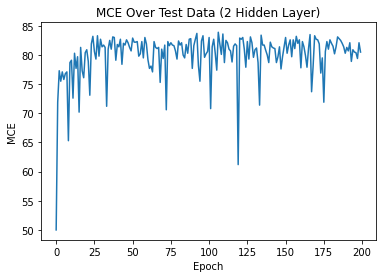

In [26]:
figureNum += 1
plt.figure(figureNum)
plt.title('MCE Over Test Data (2 Hidden Layer)')
plt.xlabel('Epoch')
plt.ylabel('MCE')
plt.plot(test_mce_2l)
plt.show()

In [27]:
# Part E

neuralNet_2L = MLP(momentum = True, momentumCoef = 0.2) 
neuralNet_2L.addLayer(HiddenLayer(32**2, 512, 0, 0.02)) 
neuralNet_2L.addLayer(HiddenLayer(512, 64, 0, 0.02))
neuralNet_2L.addLayer(HiddenLayer(64, 1, 0, 0.02)) 

mse_loss_2l_m, mce_loss_2l_m, test_mse_2l_m, test_mce_2l_m = neuralNet_2L.trainNetwork(train_img_flat/255, trainlabels,test_img_flat/255, testlabels, 0.35, 50, 200)

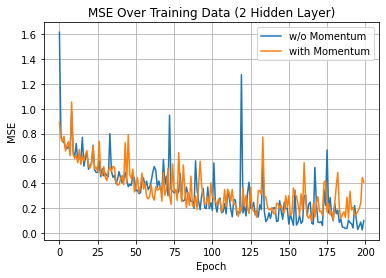

In [28]:
figureNum += 1
plt.figure(figureNum)
plt.plot(mse_loss_2l)
plt.plot(mse_loss_2l_m)

plt.title('MSE Over Training Data (2 Hidden Layer)')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.legend(["w/o Momentum", "with Momentum"])
plt.grid()
plt.show()

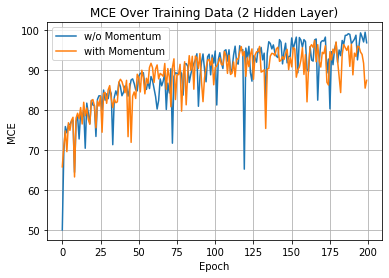

In [29]:
figureNum += 1
plt.figure(figureNum)
plt.plot(mce_loss_2l)
plt.plot(mce_loss_2l_m)

plt.title('MCE Over Training Data (2 Hidden Layer)')
plt.xlabel('Epoch')
plt.ylabel('MCE')
plt.legend(["w/o Momentum", "with Momentum"])
plt.grid()
plt.show()

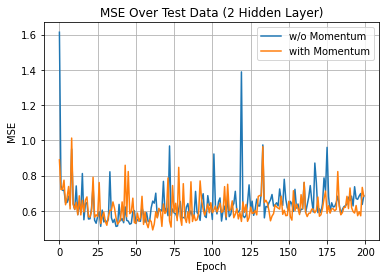

In [30]:
figureNum += 1
plt.figure(figureNum)
plt.plot(test_mse_2l)
plt.plot(test_mse_2l_m)

plt.title('MSE Over Test Data (2 Hidden Layer)')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.legend(["w/o Momentum", "with Momentum"])
plt.grid()
plt.show()

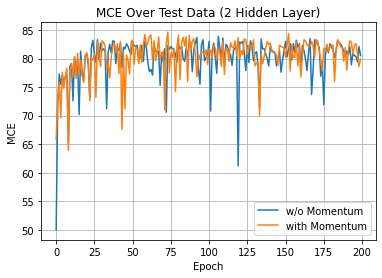

In [31]:
figureNum += 1
plt.figure(figureNum)
plt.plot(test_mce_2l)
plt.plot(test_mce_2l_m)

plt.title('MCE Over Test Data (2 Hidden Layer)')
plt.xlabel('Epoch')
plt.ylabel('MCE')
plt.legend(["w/o Momentum", "with Momentum"])
plt.grid()
plt.show()